# Tensors
TensorFow operates on multidimensional arrays or tensors represented as [tf.Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor) objects. Here is a two-dimensional tensor.

In [1]:
import tensorflow as tf

x = tf.constant([[1.,2.,3.,],
                [4.,5.,6.]])

2022-02-16 20:58:50.012572: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

#### The most important attributes of a tf.Tensor are its 'shape' and 'dtype':
* [Tensor.shape](https://www.tensorflow.org/api_docs/python/tf/Tensor#shape): tells you the size of the tensor along each of its axes.
* [Tensor.dtype](https://www.tensorflow.org/api_docs/python/tf/Tensor#dtype): tells you the type of all the elements in the tensor.

TensorFlow implrements standard mathematical operations on tensors, as well as many operations specialzed for machine learning.

For example:

In [5]:
# You can add two tensors.
x + x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [6]:
# You can multiply a tensor by a scalar quantity.
5 * x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 5., 10., 15.],
       [20., 25., 30.]], dtype=float32)>

In [10]:
# You can concat tensors.
tf.concat([x,x,x], axis=0)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

# Variables
Normal tf.Tensor objects are immutable. To store model weights (or other mutable state) in TensorFlow use a [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable).

In [11]:
var = tf.Variable([0.0, 0.0, 0.0])

In [12]:
var.assign([1,2,3])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [14]:
var.assign_add([1,1,1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

# Takeaway
It seems as tf.Tensor objects can be used with methods.

# Automatic Differentiation
[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) and related algorithms are a cornerstone of modern machine learning.

To enable this, TensorFlow implements automatic differentiation (autodiff), which uses calculus to compute gradients. Typically you'll use this to calculate the gradient of a model's error or loss with respect to its weights.

In [20]:
x = tf.Variable(1.0)

def f(x):
    y = x**2 + 2*x - 5
    return y

In [21]:
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

### TensorFlow can calculate derivatives automatically:

In [23]:
with tf.GradientTape() as tape:
    y = f(x)
    

In [24]:
g_x = tape.gradient(y,x) # g(x) = dy/dx

In [25]:
g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

# Graphs and tf.function
While you can use TensorFlow interactively like any Python library, TensorFlow aslo provides tools for:

    * **Performance optimization:** to speed up training and inference.
    * **Export:** so you can save your model when it's done training.
    
These require that you use tf.function to separate your pure-TensorFlow code from Python.

In [30]:
@tf.function
def my_func(x):
    print('Tracing.\n')
    return tf.reduce_sum(x)

The first time you run the tf.function, although it executes in Python, it captures a complete, optimized graph representing the TensorFlow computation done within the function.

In [31]:
x = tf.constant([1,2,3])

In [32]:
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [33]:
x = tf.constant([10,9,8])

In [34]:
my_func(x)

<tf.Tensor: shape=(), dtype=int32, numpy=27>

In [35]:
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)

In [36]:
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=float32, numpy=27.3>

These captured graphs provide two benefits:
    
    - In many cases they provide a significant speedup in execution (though not this trivial example).
    - You can export these graphs, using tf.saved_model, to run on other systems like a server or a mobile device, no Python installation required. 
    
Refer to [intro to graphs](https://www.tensorflow.org/guide/intro_to_graphs) for more details.

## Moduls,  layers, and models

tf.Module is a class for managing your tf.Variable objects, and the tf.function objects that operate on them. The tf.Module class is necessary to support two significant features:

1. You can save and restore the values of your variables using [tf.train.Checkpoint](https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint). This is useful during training as it is quick to sae and restore a model's state.
2. You can import and export the [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) values and the [tf.function](https://www.tensorflow.org/api_docs/python/tf/function) graphs using [tf.saved_model](https://www.tensorflow.org/api_docs/python/tf/saved_model). This allows you to run your model independently of the Python program that created it. 

Here is a complete example exporting a simple [tf.Module](https://www.tensorflow.org/api_docs/python/tf/Module) object:

In [37]:
class MyModule(tf.Module):
    def __init__(self, value):
        self.weight = tf.Variable(value)
    
    @tf.function
    def multiply(self, x):
        return x * self.weight

In [38]:
mod = MyModule(3)
mod.multiply(tf.constant([1,2,3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

**Save the Module:**

In [39]:
save_path = './saved'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ./saved/assets


2022-02-16 21:44:15.710964: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


The resulting SavedModel is independent of the code that created it. You can load a SavedModel from Python, other language bindings, or [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/docker). You can also convert it to run with [TensorFlow Lite](https://www.tensorflow.org/lite/guide) or [TensorFlow JS](https://www.tensorflow.org/js/guide).

In [40]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1,2,3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

The [tf.keras.layers.Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) and [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) classes build on [tf.Module](https://www.tensorflow.org/api_docs/python/tf/Module) providing additional functionality and convenience methods for building, training, and saving models. Some of these are demonstrated in the next section.

Refer to [intro to modules](https://www.tensorflow.org/guide/intro_to_modules) for details.

# Training Loops

Now put this all together to build a basic model and train it from scratch.

First, create some example data. This generates a cloud of points that loosely follows a quadratic curve:

In [41]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9,6]

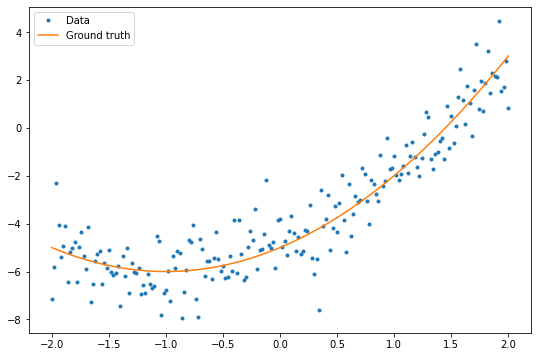

In [42]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
    y = x**2 + 2*x - 5
    return y
y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend()

**Create a model:**

In [43]:
class Model(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=units,
                                           activation=tf.nn.relu,
                                           kernel_initializer=tf.random.normal,
                                           bias_initializer=tf.random.normal)
        self.dense2 = tf.keras.layers.Dense(1)
        
    def call(self, x, training=True):
        # For Keras lyaers/models, implement 'call' instead of '__call__'.
        x = x[:, tf.newaxis]
        x = self.dense1(x)
        x = self.dense2(x)
        return tf.squeeze(x, axis=1)

In [44]:
model = Model(64)

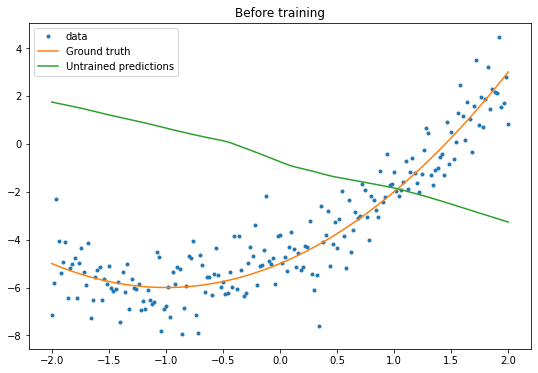

In [45]:
plt.plot(x.numpy(), y.numpy(), '.', label='data')
plt.plot(x, f(x), label='Ground truth')
plt.plot(x, model(x), label='Untrained predictions')
plt.title('Before training')
plt.legend();

**Write a basic training loop:**

In [47]:
variables = model.variables

optimizer = tf.optimizers.SGD(learning_rate=0.01)

for step in range(1000):
    with tf.GradientTape() as tape:
        prediction = model(x)
        error = (y-prediction)**2
        mean_error = tf.reduce_mean(error)
    gradient = tape.gradient(mean_error, variables)
    optimizer.apply_gradients(zip(gradient, variables))
    
    if step % 100 == 0:
        print(f'Mean squared error: {mean_error.numpy():0.3f}')

Mean squared error: 25.253
Mean squared error: 0.978
Mean squared error: 0.956
Mean squared error: 0.938
Mean squared error: 0.925
Mean squared error: 0.914
Mean squared error: 0.906
Mean squared error: 0.900
Mean squared error: 0.895
Mean squared error: 0.890


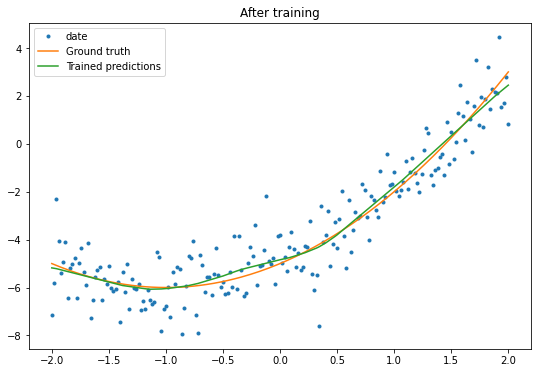

In [48]:
plt.plot(x.numpy(), y.numpy(), '.', label='date')
plt.plot(x, f(x), label='Ground truth')
plt.plot(x, model(x), label='Trained predictions')
plt.title('After training')
plt.legend();

**Implement a training loop:**

In [49]:
new_model = Model(64)

In [50]:
new_model.compile(
loss=tf.keras.losses.MSE,
optimizer=tf.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                       epochs=100,
                       batch_size=32,
                       verbose=0)

model.save('./my_model')

INFO:tensorflow:Assets written to: ./my_model/assets


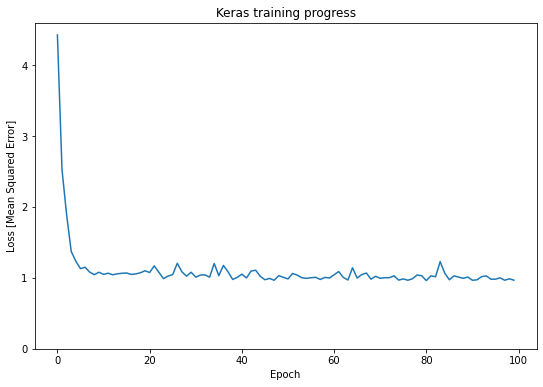

In [51]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

Refer to [Basic training loops](https://www.tensorflow.org/guide/basic_training_loops) and the [Keras guide](https://www.tensorflow.org/guide/keras) for more details.

In [ ]:
# 